# MNIST images classification: validation and metric
1- Visualize some example  
2- Load the best model  
3- Run prediction and training and testing dataset  
4- Visualize predictions on testing dataset  
5- Confusion matrix
6- ROC curves  
7- Model interpretation with LIME

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
   workingdir=str(pathlib.Path(workingdir).parents[0])
   print(workingdir)
   d=[d for d in os.listdir(str(workingdir))]
   n+=1
   if n>5:
       break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [108]:
import os
#import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
#from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
#from keras.models import load_model
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
#from itertools import cycle
#from sklearn.metrics import roc_curve, auc
#from scipy import interp
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [48]:
tf.__version__

'1.12.0'

### Import our utils functions

In [49]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_v1.trainer.model as mnist_v1

In [90]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

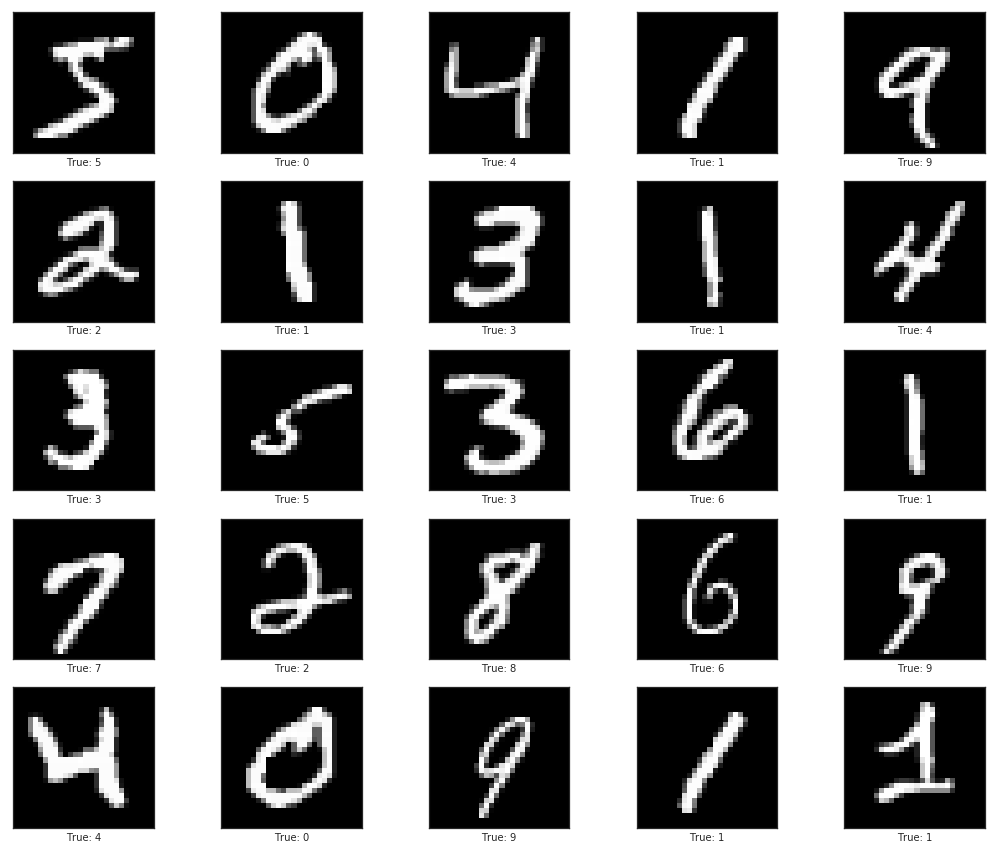

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [10]:
tf.logging.set_verbosity(tf.logging.INFO)

In [11]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model version
MODEL='v1'

## Defined flags

In [12]:
tensorflow_helper.del_all_flags(tf.flags.FLAGS)

In [13]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('f', '', 'kernel') 

# path to store the model and input for Tensorboard
tf.app.flags.DEFINE_string('model_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/ckpt/', 'Dir to save a model and checkpoints with keras')
tf.app.flags.DEFINE_string('tensorboard_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/logs/', 'Dir to save logs for TensorBoard with keras')

# parameters for the input dataset and train the model
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
tf.app.flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
tf.app.flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = tf.app.flags.FLAGS

## Load Model with the best accuracy

In [14]:
# best model
best_model=FLAGS.model_dir_keras+'keras_model.h5'

# load the weights with the best validation accuracy
best_model = tf.keras.models.load_model(best_model)

## Input dataset

### Input dataset functions for training

In [15]:
training_dataset = mnist_v1.input_mnist_array_dataset_fn(x_train, 
                                                         y_train, 
                                                         FLAGS,
                                                         mode=tf.estimator.ModeKeys.TRAIN, 
                                                         batch_size=FLAGS.batch_size)

INFO:tensorflow:input_dataset_fn: TRAIN, train


### Input dataset functions for testing

In [16]:
testing_dataset = mnist_v1.input_mnist_array_dataset_fn(x_test, 
                                                        y_test,
                                                        FLAGS,
                                                        mode=tf.estimator.ModeKeys.EVAL, 
                                                        batch_size=len(x_test))

INFO:tensorflow:input_dataset_fn: EVAL, eval


## Accuracy and losses

### Training dataset

In [17]:
# evaluate the model on test set
score = best_model.evaluate(training_dataset, 
                            steps=FLAGS.step_per_epoch,
                            verbose=1)

# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score[1]))

468/468 [==============================] - 5s 11ms/step
Loss:
  - loss [testing dataset]: 0.103

Accuracy:
  - accuracy [testing dataset]: 97.29%


### Test dataset

In [18]:
# evaluate the model on training set
score = best_model.evaluate(testing_dataset, 
                            steps=1,
                            verbose=1)

# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score[1]))

1/1 [==============================] - 1s 1s/step
Loss:
  - loss [training dataset]: 0.167

Accuracy:
  - accuracy [training dataset]: 96.30%


In [19]:
score = best_model.test_on_batch(testing_dataset)

# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score[1]))

Loss:
  - loss [training dataset]: 0.167

Accuracy:
  - accuracy [training dataset]: 96.30%


### Predictions

In [20]:
pred_proba_train = best_model.predict(training_dataset,
                                      steps=FLAGS.step_per_epoch)
print('number of prediction and shape of the array', pred_proba_train.shape)

number of prediction and shape of the array (59904, 10)


In [21]:
pred_proba_test = best_model.predict(testing_dataset,
                                     steps=1)
print('number of prediction and shape of the array', pred_proba_test.shape)

number of prediction and shape of the array (10000, 10)


### Predictions per batch

In [22]:
pred_proba_train_b = best_model.predict_on_batch(training_dataset)
print('number of prediction and shape of the array', pred_proba_train_b.shape)

number of prediction and shape of the array (128, 10)


In [23]:
pred_proba_test_b = best_model.predict_on_batch(testing_dataset)
print('number of prediction and shape of the array', pred_proba_test_b.shape)

number of prediction and shape of the array (10000, 10)


## Visualize predictions on testing dataset

In [24]:
predict_classes = np.argmax(pred_proba_test, axis = 1)
true_classes = y_test

In [25]:
# mapping classes and name
dict_label=['0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9']

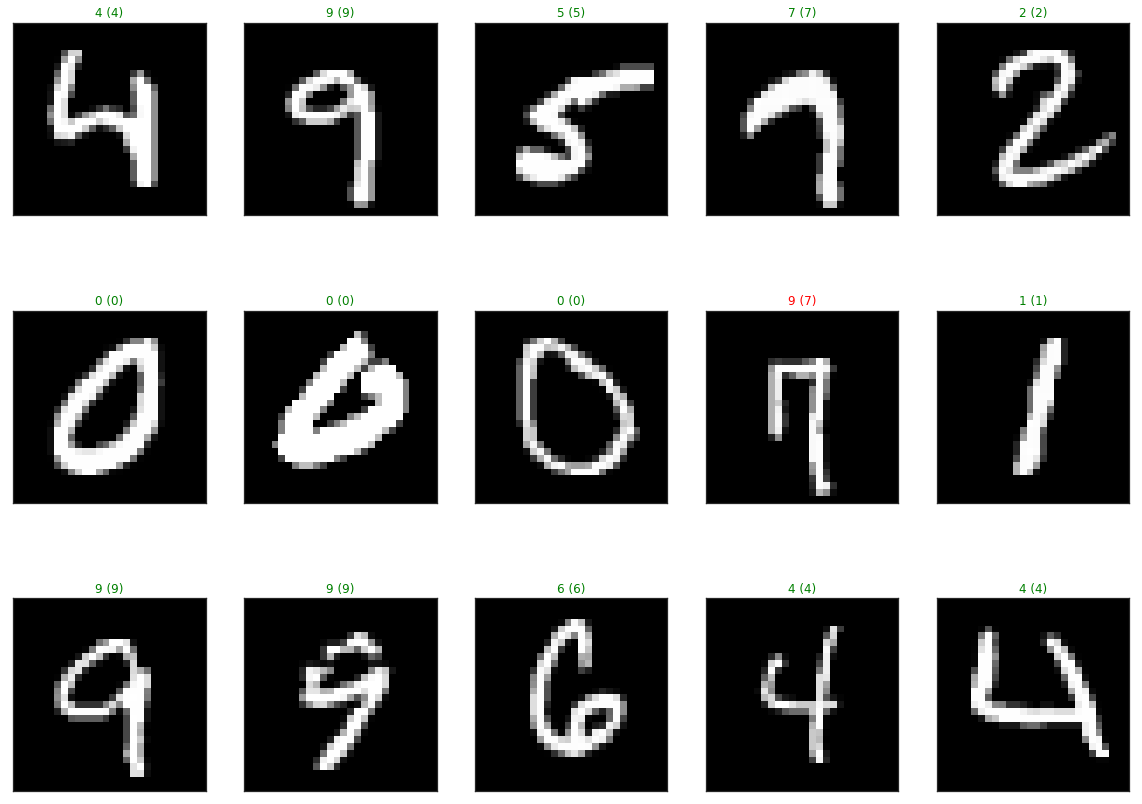

In [26]:
# plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
   
    # display each image
    ax.imshow(x_test[index], cmap=plt.cm.gray)
    predict_index = predict_classes[index]#np.argmax(y_hat[index])
    true_index = true_classes[index] # no encoding
    
    # set the title for each image
    ax.set_title("{} ({})".format(dict_label[predict_index], 
                                  dict_label[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Metrics

<img src="../doc/img/metrics.png" width=600 align="left">

In [27]:
 print(classification_report(true_classes, predict_classes, target_names=dict_label))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.98      0.94      0.96      1010
           4       0.97      0.95      0.96       982
           5       0.95      0.97      0.96       892
           6       0.98      0.97      0.98       958
           7       0.98      0.93      0.96      1028
           8       0.93      0.97      0.95       974
           9       0.92      0.97      0.94      1009

   micro avg       0.96      0.96      0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



## Confusion matrix

### Simple confusion matrix

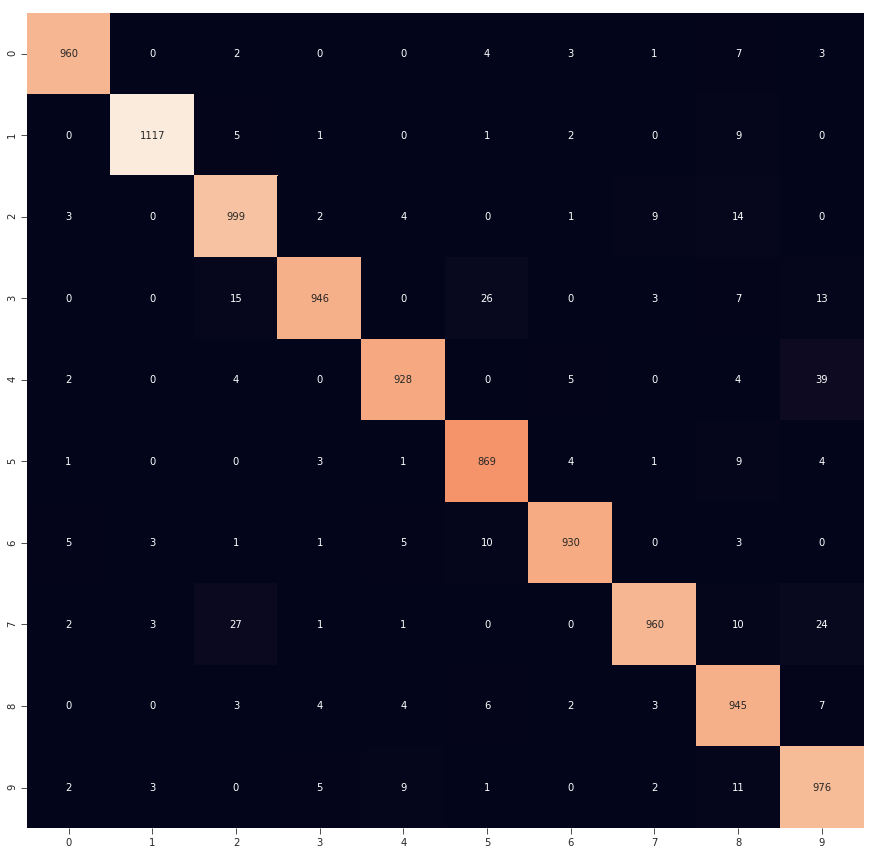

In [29]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(confusion_matrix(true_classes, predict_classes), 
            annot=True, cbar=False, fmt='d', ax=ax)
ax.set_yticklabels(dict_label, minor=False)
ax.set_xticklabels(dict_label, minor=False);

### Confusion matrix with more informations

In [54]:
# compute confusion matrix
cnf_matrix = confusion_matrix(true_classes, predict_classes)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 960    0    2    0    0    4    3    1    7    3]
 [   0 1117    5    1    0    1    2    0    9    0]
 [   3    0  999    2    4    0    1    9   14    0]
 [   0    0   15  946    0   26    0    3    7   13]
 [   2    0    4    0  928    0    5    0    4   39]
 [   1    0    0    3    1  869    4    1    9    4]
 [   5    3    1    1    5   10  930    0    3    0]
 [   2    3   27    1    1    0    0  960   10   24]
 [   0    0    3    4    4    6    2    3  945    7]
 [   2    3    0    5    9    1    0    2   11  976]]


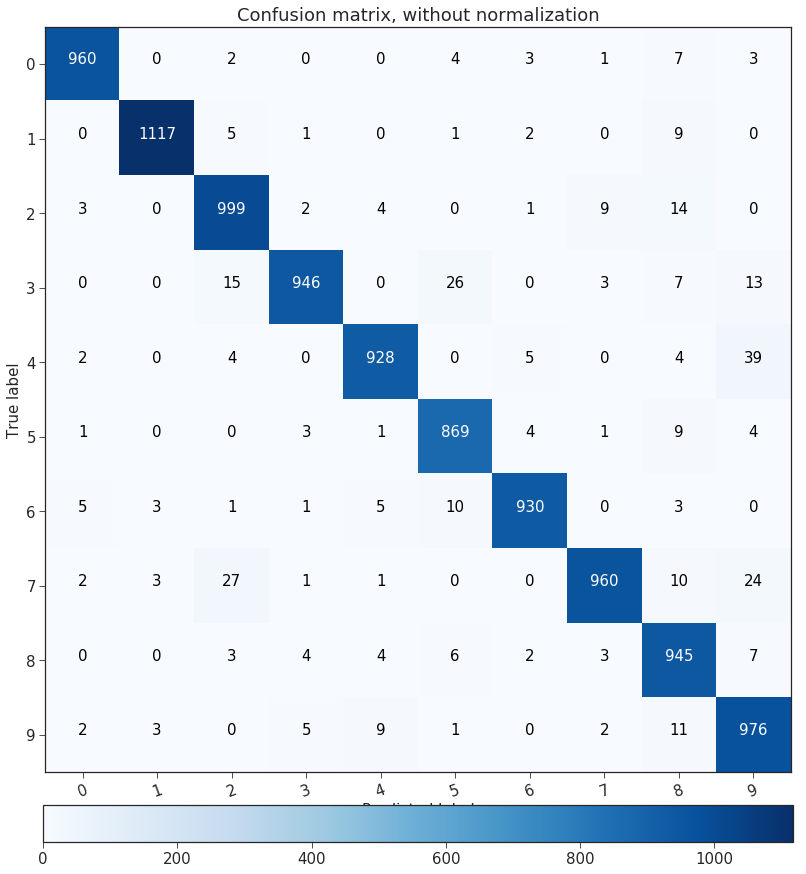

In [55]:
# plot non-normalized confusion matrix
ml_utils.plot_confusion_matrix(cnf_matrix, classes=dict_label,title='Confusion matrix, without normalization')

Normalized confusion matrix
[[9.80e-01 0.00e+00 2.04e-03 0.00e+00 0.00e+00 4.08e-03 3.06e-03 1.02e-03
  7.14e-03 3.06e-03]
 [0.00e+00 9.84e-01 4.41e-03 8.81e-04 0.00e+00 8.81e-04 1.76e-03 0.00e+00
  7.93e-03 0.00e+00]
 [2.91e-03 0.00e+00 9.68e-01 1.94e-03 3.88e-03 0.00e+00 9.69e-04 8.72e-03
  1.36e-02 0.00e+00]
 [0.00e+00 0.00e+00 1.49e-02 9.37e-01 0.00e+00 2.57e-02 0.00e+00 2.97e-03
  6.93e-03 1.29e-02]
 [2.04e-03 0.00e+00 4.07e-03 0.00e+00 9.45e-01 0.00e+00 5.09e-03 0.00e+00
  4.07e-03 3.97e-02]
 [1.12e-03 0.00e+00 0.00e+00 3.36e-03 1.12e-03 9.74e-01 4.48e-03 1.12e-03
  1.01e-02 4.48e-03]
 [5.22e-03 3.13e-03 1.04e-03 1.04e-03 5.22e-03 1.04e-02 9.71e-01 0.00e+00
  3.13e-03 0.00e+00]
 [1.95e-03 2.92e-03 2.63e-02 9.73e-04 9.73e-04 0.00e+00 0.00e+00 9.34e-01
  9.73e-03 2.33e-02]
 [0.00e+00 0.00e+00 3.08e-03 4.11e-03 4.11e-03 6.16e-03 2.05e-03 3.08e-03
  9.70e-01 7.19e-03]
 [1.98e-03 2.97e-03 0.00e+00 4.96e-03 8.92e-03 9.91e-04 0.00e+00 1.98e-03
  1.09e-02 9.67e-01]]


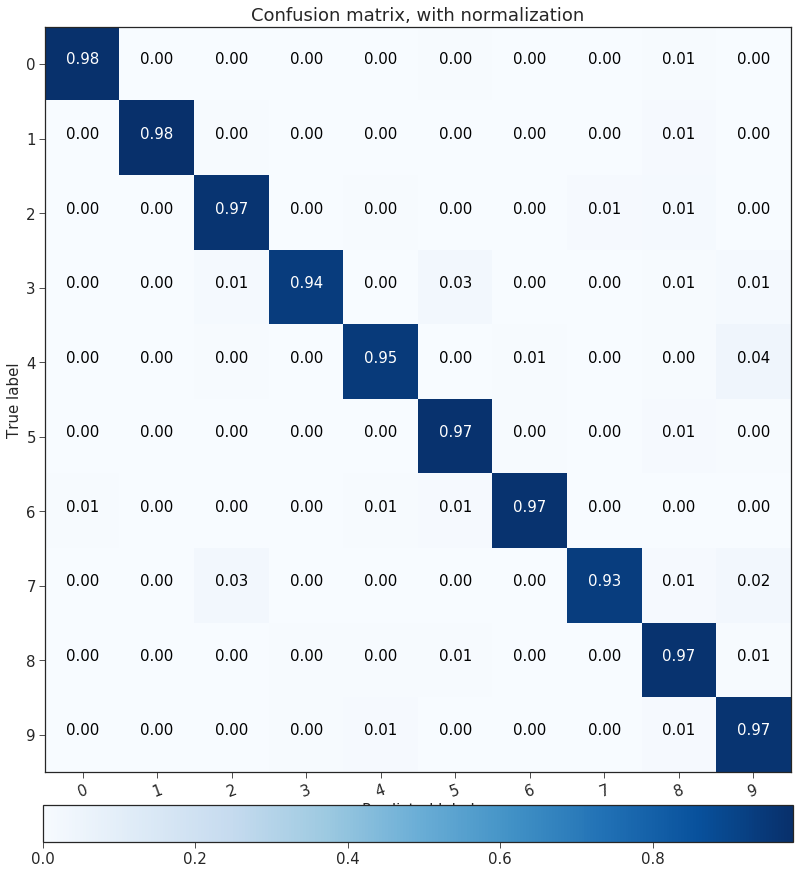

In [56]:
# plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,normalize=True,
                      title='Confusion matrix, with normalization')

## ROC curves

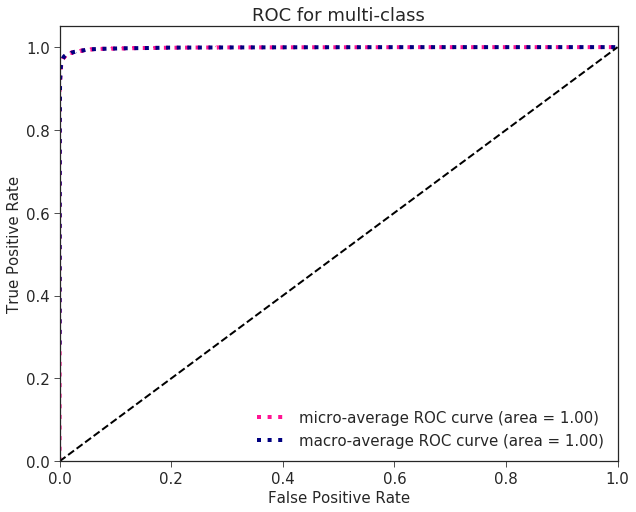

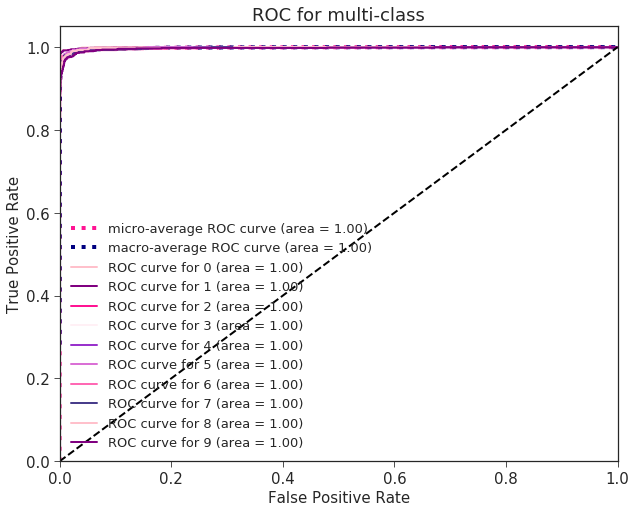

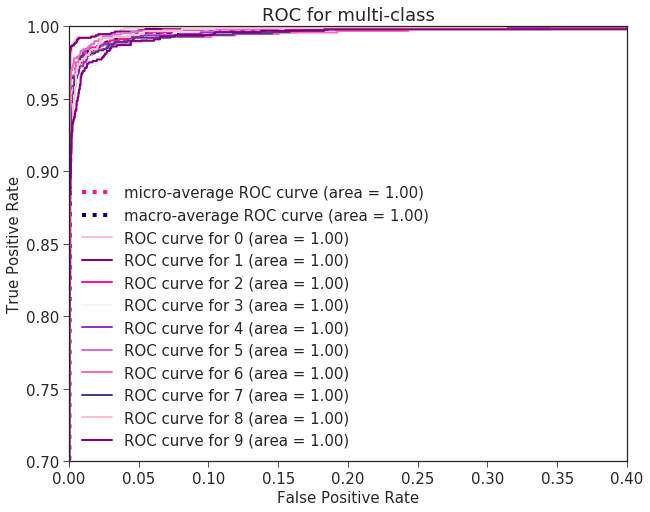

In [91]:
ml_utils.roc_curves(tf.keras.utils.to_categorical(y_test, pred_proba_test.shape[1]), pred_proba_test, dict_label)

## Model interpretation
### Helper functions

In [92]:
def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)

### Example pf correct classified classes

In [93]:
correctly_classified_indices, misclassified_indices = evaluation_indices(predict_classes, true_classes)

In [94]:
# inspecting class labels for future reference 
labels_index = {0 : '0', 
                1 : '1',
                2 : '2',
                3 : '3',
                4 : '4',
                5 : '5',
                6 : '6',
                7 : '7',
                8 : '8',
                9 : '9'}

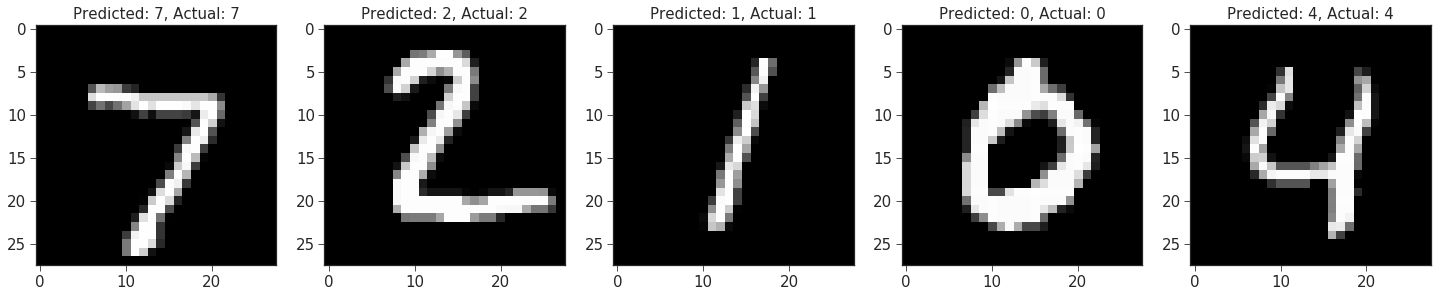

In [99]:
plt.figure(figsize=(25,5))
#shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(x_test[good_index], cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_classes[good_index]], 
                                                 labels_index[true_classes[good_index]]), fontsize = 15)

### Compute exampel with the coorect preprocessing

In [103]:
iterator = testing_dataset.make_one_shot_iterator()
features, labels = iterator.get_next()
debug_info=False
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x_test_pp, y_test_pp = sess.run([features, labels])
            if  debug_info:
                print(time.clock() - start_time, 'seconds')
                print(x_test_pp.shape)
                print(y_test_pp.shape)
                print('first label of the batch',np.argmax(y_test_pp[0]),'\n')
            
            # we just need the full dataset so one epoch
            break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

### Use LIME for correct classified classes

In [110]:
x_test_pp[0].shape

(784,)

In [ ]:
def new_predict_fn(images):
    images = convert_to_1channel(images)
    return best_model.predict(images)

ValueError: the input array must be have a shape == (.., ..,[ ..,] 3)), got (1, 784, 1)

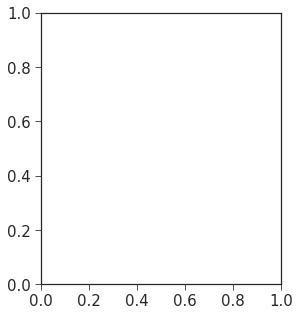

In [107]:
plt.figure(figsize=(25,5))
#shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(x_test_pp[good_index], best_model.predict, top_labels=10, hide_color=0, num_samples=1000)
    #temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    #x = mark_boundaries(temp / 2 + 0.5, mask)
    #plt.imshow(x, interpolation='none')
    #plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[good_index]], 
    #                                             labels_index[true_index[good_index]]), fontsize = 15)

### Use LIME for incorrect classified classes

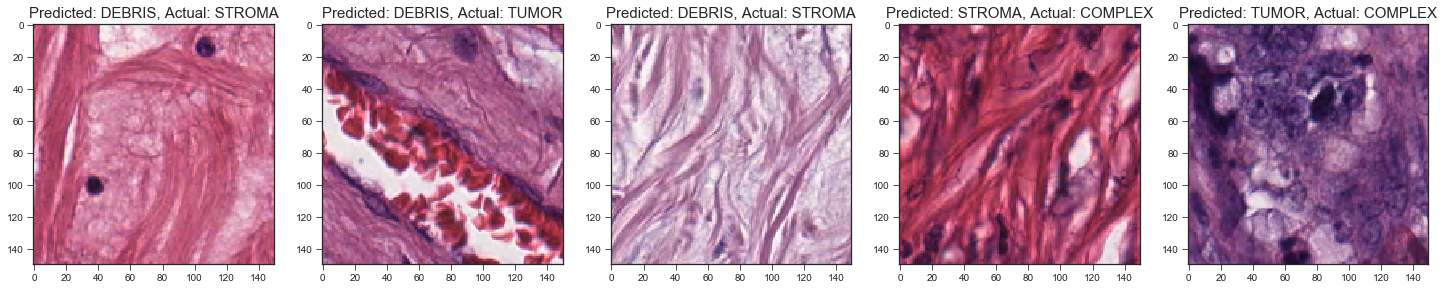

In [155]:
plt.figure(figsize=(25,5))
#shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate( misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(x_test[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[good_index]], 
                                                 labels_index[true_index[good_index]]), fontsize = 15)

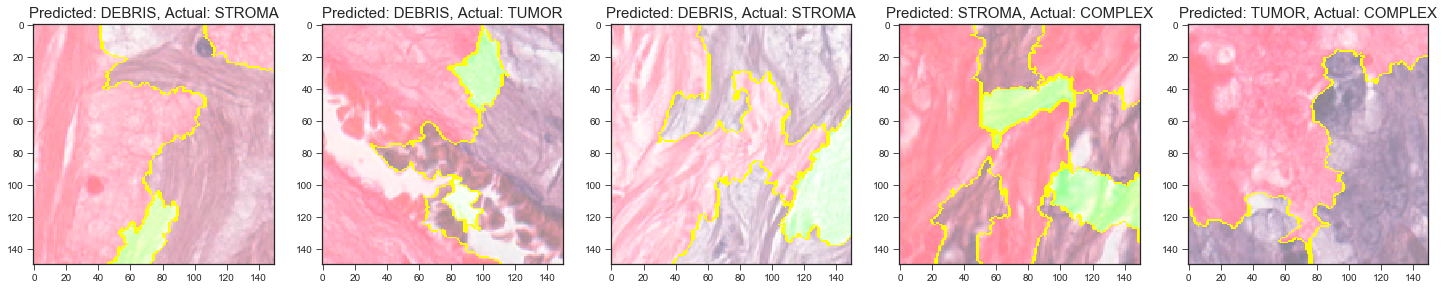

In [157]:
plt.figure(figsize=(25,5))
#shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(x_test[bad_index], best_model.predict, top_labels=8, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[bad_index]], 
                                                 labels_index[true_index[bad_index]]), fontsize = 15)